In [40]:
import numpy as np
import matplotlib.pyplot as plt

In [41]:
events = np.loadtxt("../../data_processed/events_corner_filt.txt")

In [50]:
#events = np.loadtxt("../data/events.txt")
time_range = [3.0, 3.4]
idx_range = [np.searchsorted(events[:,0], time_range[0]), np.searchsorted(events[:,0], time_range[1])]
events = events[idx_range[0]:idx_range[1], :]

In [51]:
def filter_patch(events, patch_center, patch_size):
    x_lim = (patch_center[1] - int(patch_size / 2), patch_center[1] + int(patch_size / 2) - 1)
    y_lim = (patch_center[0] - int(patch_size / 2), patch_center[0] + int(patch_size / 2) - 1)

    events_filtered = np.copy(events)
    events_filtered = events_filtered[
        np.logical_and((x_lim[0] <= events_filtered[:, 1]), (events_filtered[:, 1] <= x_lim[1]))]
    events_filtered = events_filtered[
        np.logical_and((y_lim[0] <= events_filtered[:, 2]), (events_filtered[:, 2] <= y_lim[1]))]
    # events_filtered = events_filtered[[(y_lim[0] >= events_range[:,2]) & (events_range[:,2] <= y_lim[1])]
    #vents_filtered = np.array(events_filtered)

    events_filtered[:,1] = (events_filtered[:,1] - patch_center[1] + int(patch_size / 2)).astype(int)
    events_filtered[:,2] = (events_filtered[:,2] - patch_center[0] + int(patch_size / 2)).astype(int)
    
    return events_filtered

In [52]:
patch_center = (90, 90)
patch_size = 180
shape = (patch_size, patch_size)
events = filter_patch(events, patch_center, patch_size)

In [53]:
t_start = events[0, 0]

In [54]:
last_time = np.zeros(shape)
time_difference = np.zeros(shape)
for e in events:
    if e[3] == 1:
        continue
    
    x = int(e[1])
    y = int(e[2])
    
    last_time[y, x] = e[0]
    
    if x == shape[1] -1:
        continue
    
    if last_time[y, x+1] != 0:
        time_difference[y, x] = e[0] - last_time[y, x+1]

In [55]:
# conv_shape = (3, 3)
# conv_stride = (3, 3)
# result_shape = (int(shape[0]/conv_stride[0]), int(shape[1]/conv_stride[1]))
# dict_px = {} 
# dict_t = {}
# for x in range(time_difference.shape[1]):
#     for y in range(time_difference.shape[0]):
#         if time_difference[y, x] == 0:
#             continue

#         x_c = int(x / conv_stride[0])
#         y_c = int(y / conv_stride[1])

#         if (y_c, x_c) in dict_px:
#             dict_px[y_c, x_c].append(time_difference[y, x])
#         else:
#             dict_px[y_c, x_c] = [time_difference[y, x]]
            
#         if (y_c, x_c) in dict_t:
#             dict_t[y_c, x_c].append(last_time[y, x])
#         else:
#             dict_t[y_c, x_c] = [last_time[y, x]]

In [56]:
# time_diff_med = np.zeros(result_shape)
# for k in dict_px:
#     y = k[0]
#     x = k[1]
#     if len(dict_px[k]) <= 2:
#         continue
#     time_diff_med[y, x] = np.median(dict_px[k])

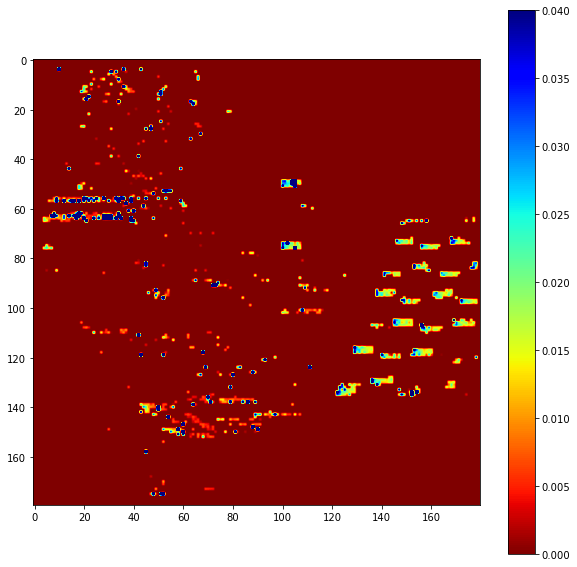

In [57]:
%matplotlib inline
plt.figure(figsize=(10, 10))
m = plt.imshow(time_difference, cmap="jet_r", vmax=0.04)
plt.colorbar(mappable=m)

In [58]:
time_diff_m = np.ma.masked_where(time_difference<=0, time_difference)
u = np.divide(1, time_diff_m, where=time_difference > 0)

In [59]:
v = 0.2901460156636141

In [60]:
f = 335.419462958

In [61]:
d = np.divide(f, u, where=u>0.0) * v

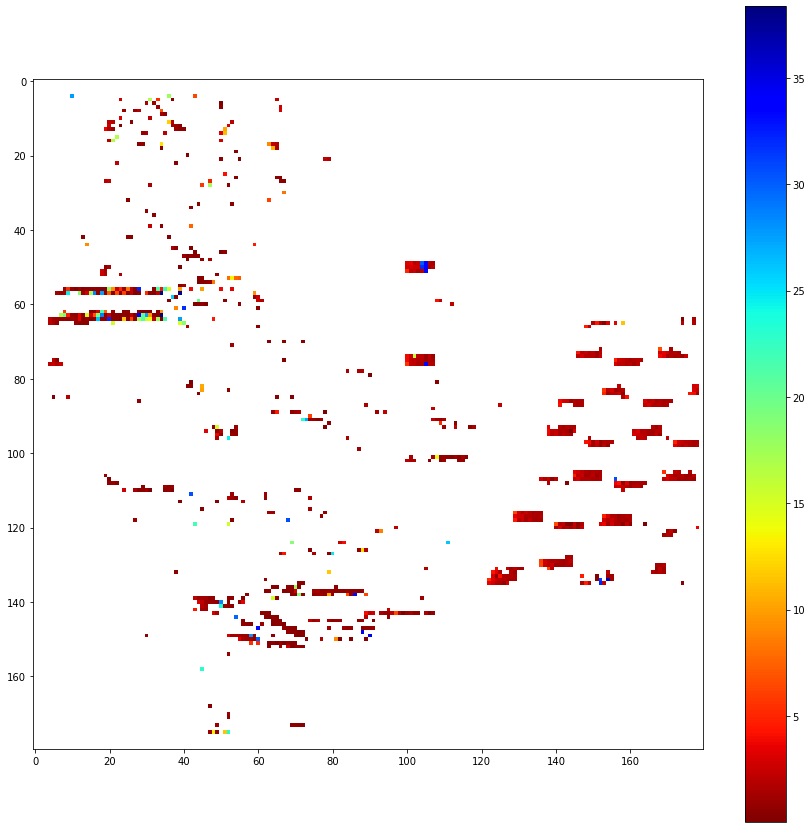

In [62]:
plt.figure(figsize=(15, 15))
m = plt.imshow(d, cmap="jet_r")
plt.colorbar(m)

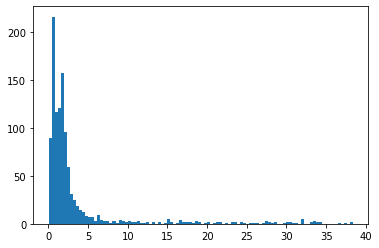

In [63]:
plt.hist(d.compressed(), 100);

In [64]:
points = []
for x in range(d.shape[1]):
    for y in range(d.shape[0]):
        if d.mask[y, x] or d.data[y, x] > 3:
            continue
        points.append([x, y, d.data[y, x]])
points = np.array(points)

In [67]:
%matplotlib qt
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.scatter(points[:,0], points[:,1], points[:,2],s=10, c=points[:,2], cmap="jet_r")
ax.set_zlim3d([0, 3])
plt.show()

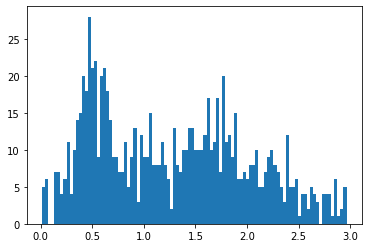

In [68]:
%matplotlib inline
plt.hist(points[:,2], 100);

In [71]:
img_corr = np.copy(d.data)
img_count = np.zeros(img_corr.shape)

for x in range(img_corr.shape[1] -1, -1, -1):
    for y in range(img_corr.shape[0]):
        if d.mask[y, x]:
            img_corr[y, x] = 0
            continue
        if x == 0:
            continue
        if img_corr[y, x] == 0:
            continue

        if not d.mask[y, x-1] and img_corr[y, x-1] != 0:
            img_corr[y, x-1] += img_corr[y, x]
            img_corr[y, x] = 0
            img_count[y, x-1] += img_count[y, x] + 1
            
img_corr_d = np.divide(img_corr, img_count, where=img_count!=0)

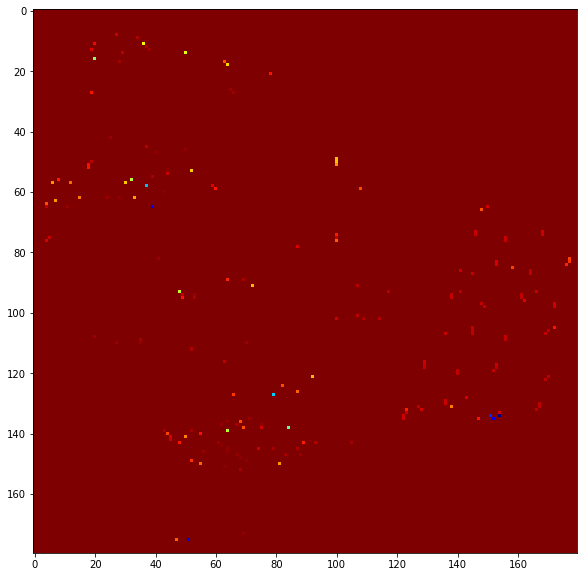

In [72]:
%matplotlib inline
plt.figure(figsize=(10, 10))
m = plt.imshow(img_corr_d, cmap="jet_r")
#plt.colorbar(mappable=m)

In [73]:
img_corr_m = np.ma.masked_where(img_corr_d<=0, img_corr_d)
points = []
for x in range(d.shape[1]):
    for y in range(d.shape[0]):
        if img_corr_d[y, x] == 0:
            continue
        points.append([x, y, img_corr_d[y, x]])
points = np.array(points)

In [74]:
%matplotlib qt
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.scatter(points[:,0], points[:,1], points[:,2],s=10, c=points[:,2], cmap="jet_r")
ax.set_zlim3d([0.1, 5])
plt.show()

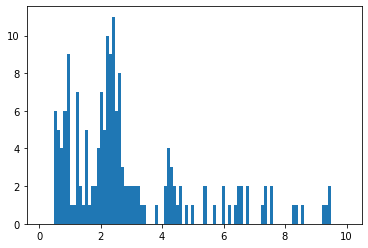

In [75]:
%matplotlib inline
plt.hist(points[:,2], 100, range=(0.1, 10));

# Warping on the time difference between detected corners

In [122]:
events = np.loadtxt("../../data_processed/events_corner_filt.txt")

In [123]:
#events = np.loadtxt("../data/events.txt")
time_range = [2.6, 3.0]
idx_range = [np.searchsorted(events[:,0], time_range[0]), np.searchsorted(events[:,0], time_range[1])]
events = events[idx_range[0]:idx_range[1], :]

In [124]:
def filter_patch(events, patch_center, patch_size):
    x_lim = (patch_center[1] - int(patch_size / 2), patch_center[1] + int(patch_size / 2) - 1)
    y_lim = (patch_center[0] - int(patch_size / 2), patch_center[0] + int(patch_size / 2) - 1)

    events_filtered = np.copy(events)
    events_filtered = events_filtered[
        np.logical_and((x_lim[0] <= events_filtered[:, 1]), (events_filtered[:, 1] <= x_lim[1]))]
    events_filtered = events_filtered[
        np.logical_and((y_lim[0] <= events_filtered[:, 2]), (events_filtered[:, 2] <= y_lim[1]))]
    # events_filtered = events_filtered[[(y_lim[0] >= events_range[:,2]) & (events_range[:,2] <= y_lim[1])]
    #vents_filtered = np.array(events_filtered)

    events_filtered[:,1] = (events_filtered[:,1] - patch_center[1] + int(patch_size / 2)).astype(int)
    events_filtered[:,2] = (events_filtered[:,2] - patch_center[0] + int(patch_size / 2)).astype(int)
    
    return events_filtered

In [125]:
patch_center = (90, 90)
patch_size = 180
shape = (patch_size, patch_size)
events = filter_patch(events, patch_center, patch_size)
t_start = events[0, 0]

In [126]:
def img_from_events(events):
    img_height = int(events[:,2].max()+1)
    img_width = int(events[:,1].max()+1)
    img = np.zeros((img_height, img_width))
    for e in events:
        if e[3] == 1:
            continue
        x = int(e[1])
        y = int(e[2])
        img[y, x] += 1
    return img

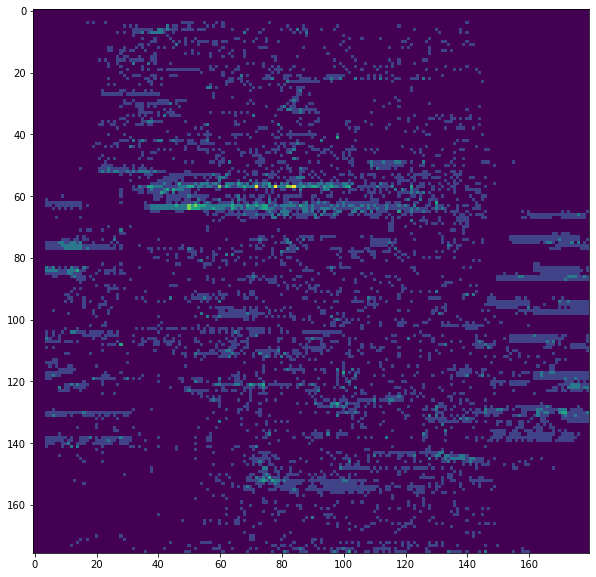

In [127]:
plt.figure(figsize=(10, 10))
plt.imshow(img_from_events(events))

In [128]:
last_time = np.zeros(shape)
time_diff_dict = {}
dist = 1
warped_shape = (180, 300)
for e in events:
    if e[3] == 1:
        continue
    
    x = int(e[1])
    y = int(e[2])
    
    last_time[y, x] = e[0]
    
    if x >= shape[1] - dist:
        continue
    
    if last_time[y, x+dist] != 0:
        speed = dist/(e[0] - last_time[y, x+dist])
        warp_pos_x = int(x + (e[0] - t_start) * speed)
        if warp_pos_x >= warped_shape[1]:
            continue
        if (y, warp_pos_x) in time_diff_dict:
            time_diff_dict[y, warp_pos_x].append(speed)
        else:
            time_diff_dict[y, warp_pos_x] = [speed]

In [129]:
warped_img = np.zeros(warped_shape)
for k in time_diff_dict:
    y = k[0]
    x = k[1]
    if len(time_diff_dict[k]) <= 1:
        continue
    warped_img[y, x] = np.median(time_diff_dict[k])

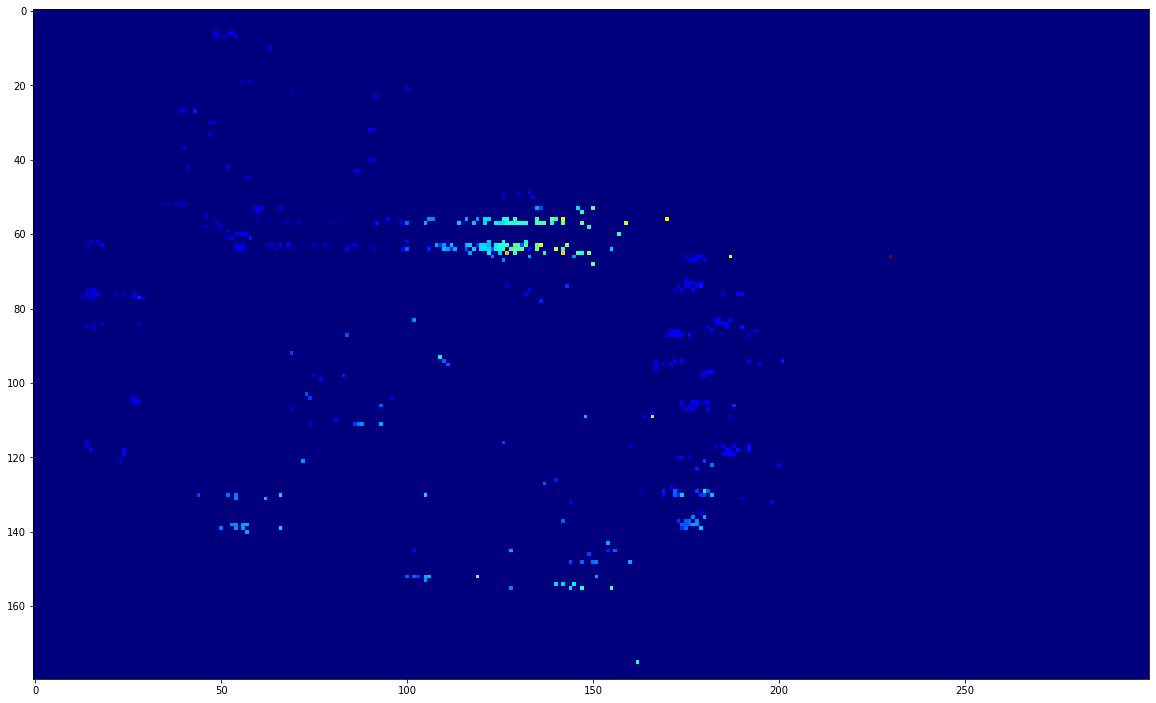

In [130]:
%matplotlib inline
#time_diff_fil = np.ma.masked_where(time_difference < 2, time_difference)
plt.figure(figsize=(20, 20))
plt.imshow(warped_img, cmap="jet")